# Product Review Classification

## Business Understanding
Our company wants a tool that will automatically classify product reviews as _positive_ or _negative_ reviews, based on the features of the review.  This will help our Product team to perform more sophisticated analyses in the future to help ensure customer satisfaction.

## Data Understanding
We have a labeled collection of 20,000 product reviews, with an equal split of positive and negative reviews. The dataset contains the following features:

 - `ProductId` Unique identifier for the product
 - `UserId` Unqiue identifier for the user
 - `ProfileName` Profile name of the user
 - `HelpfulnessNumerator` Number of users who found the review helpful
 - `HelpfulnessDenominator` Number of users who indicated whether they found the review helpful or not
 - `Time` Timestamp for the review
 - `Summary` Brief summary of the review
 - `Text` Text of the review
 - `PositiveReview` 1 if this was labeled as a positive review, 0 if it was labeled as a negative review

In [117]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix

In [126]:
cm_plot_labels = ['negative_review','positive_review']

def plot_confusion_matrix_nn(cm, classes=cm_plot_labels,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [105]:
df = pd.read_csv("reviews.csv")
df.head(3)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,PositiveReview
0,B002QWHJOU,A37565LZHTG1VH,C. Maltese,1,1,1305331200,Awesome!,This is a great product. My 2 year old Golden ...,1
1,B000ESLJ6C,AMUAWXDJHE4D2,angieseashore,1,1,1320710400,Was there a recipe change?,I have been drinking Pero ever since I was a l...,0
2,B004IJJQK4,AMHHNAFJ9L958,A M,0,1,1321747200,These taste so bland.,"Look, each pack contains two servings of 120 c...",0


The data has already been cleaned, so there are no missing values

In [106]:
df.shape

(20000, 9)

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ProductId               20000 non-null  object
 1   UserId                  20000 non-null  object
 2   ProfileName             20000 non-null  object
 3   HelpfulnessNumerator    20000 non-null  int64 
 4   HelpfulnessDenominator  20000 non-null  int64 
 5   Time                    20000 non-null  int64 
 6   Summary                 20000 non-null  object
 7   Text                    20000 non-null  object
 8   PositiveReview          20000 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.4+ MB


In [108]:
df.isna().sum()

ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Time                      0
Summary                   0
Text                      0
PositiveReview            0
dtype: int64

`PositiveReview` is the target, and all other columns are features

In [109]:
X = df.drop("PositiveReview", axis=1)
y = df["PositiveReview"]

## Data Preparation

First, split into train and test sets

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape

(15000, 8)

Second, prepare for modeling. The following `Pipeline` prepares all data for modeling.  It one-hot encodes the `ProductId`, applies a tf-idf vectorizer to the `Summary` and `Text`, keeps the numeric columns as-is, and drops all other columns.

The following code may take up to 1 minute to run.

In [111]:
def drop_irrelevant_columns(X):
    return X.drop(["UserId", "ProfileName"], axis=1)

pipeline = Pipeline(steps=[
    ("drop_columns", FunctionTransformer(drop_irrelevant_columns)),
    ("transform_text_columns", ColumnTransformer(transformers=[
        ("ohe", OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False), ["ProductId"]),
        ("summary-tf-idf", TfidfVectorizer(max_features=1000), "Summary"),
        ("text-tf-idf", TfidfVectorizer(max_features=1000), "Text")
    ], remainder="passthrough"))
])

X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

X_train_transformed.shape

(15000, 11275)

## Modeling

Fit a `RandomForestClassifier` with the best hyperparameters.  The following code may take up to 1 minute to run.

In [112]:
rfc = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=30,
    min_samples_split=15,
    min_samples_leaf=1
)
rfc.fit(X_train_transformed, y_train)

RandomForestClassifier(max_depth=30, min_samples_split=15, random_state=42)

## Model Evaluation

We are using _accuracy_ as our metric, which is the default metric in Scikit-Learn, so it is possible to just use the built-in `.score` method

In [113]:
print("Train accuracy:", rfc.score(X_train_transformed, y_train))
print("Test accuracy:", rfc.score(X_test_transformed, y_test))

Train accuracy: 0.9846666666666667
Test accuracy: 0.9116


In [114]:
print("Train confusion matrix:")
print(confusion_matrix(y_train, rfc.predict(X_train_transformed)))
print("Test confusion matrix:")
print(confusion_matrix(y_test, rfc.predict(X_test_transformed)))

Train confusion matrix:
[[7323  166]
 [  64 7447]]
Test confusion matrix:
[[2286  225]
 [ 217 2272]]


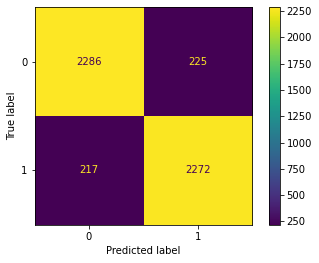

In [119]:
plot_confusion_matrix(rfc, X_test_transformed, y_test);

## Business Interpretation

The tuned Random Forest Classifier model appears to be somewhat overfit on the training data, but nevertheless achieves 91% accuracy on the test data.  Of the 9% of mislabeled comments, about half are false positives and half are false negatives.

Because this is a balanced dataset, 91% accuracy is a substantial improvement over a 50% baseline.  This model is ready for production use for decision support.

### 1) Data Preparation
A train-test split has already been performed.
Additionally, there is already a pipeline in place that drops some columns and converts all text columns into a numeric format for modeling.
**Your only additional data preparation task is feature scaling.**  Tree-based models like Random Forest Classifiers do not require scaling, but TensorFlow neural networks do.
There are two main strategies you can take for this task:
#### Scaling within the existing pipeline
If you are comfortable with pipelines, this is the more polished/professional route.
1. Make a new pipeline, with a `StandardScaler` as the final step.  You can nest the steps of the previous pipeline inside of this new pipeline
2. Generate a new `X_train_transformed_scaled` by calling `.fit_transform` on the new pipeline
3. Generate a new `X_test_transformed_scaled` by calling `.transform` on the new pipeline
#### Scaling after the pipeline has finished
This is a better strategy if you are not as comfortable with pipelines.
1. Instantiate a `StandardScaler` object
2. Generate a new `X_train_transformed_scaled` by calling `.fit_transform` on the scaler object, after you have called `.fit_transform` on the pipeline
3. Generate a new `X_test_transformed_scaled` by calling `.transform` on the scaler object, after you have called `.transform` on the pipeline
If you are getting stuck at this step, skip it.  The model will still be able to fit, although the performance will be worse.  Keep in mind whether or not you scaled the data in your final analysis.

In [13]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

X_train_transformed_scaled = ss.fit_transform(X_train_transformed)

X_test_transformed_scaled = ss.transform(X_test_transformed)

In [16]:
X_train_transformed_scaled.shape

(15000, 11275)

### 2) Modeling
Build a neural network classifier.  Specifically, use the `keras` submodule of the `tensorflow` library to build a multi-layer perceptron model with the `Sequential` interface.
See the [`tf.keras` documentation](https://www.tensorflow.org/guide/keras/overview) for an overview on the use of `Sequential` models. See the [Keras layers documentation](https://keras.io/layers/core/) for descriptions of the `Dense` layer options.  
1. Instantiate a `Sequential` model
2. Add an input `Dense` layer.  You'll need to specify a `input_shape` = (11275,) because this is the number of features of the transformed dataset.
3. Add 2 `Dense` hidden layers.  They can have any number of units, but keep in mind that more units will require more processing power.  We recommend an initial `units` of 64 for processing power reasons.
4. Add a final `Dense` output layer.  This layer must have exactly 1 unit because we are doing a binary prediction task.
5. Compile the `Sequential` model
6. Fit the `Sequential` model on the preprocessed training data (`X_train_transformed_scaled`) with a b`batch_size` of 50 and `epochs` of 5 for processing power reasons.

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [30]:
# fsm model

model = model_fsm = Sequential()


model.add(Dense(units=6, activation='relu', input_shape=(X_train_transformed_scaled.shape[1],)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['Accuracy'])
model.fit(X_train_transformed_scaled, y_train, batch_size=50, epochs=5)

Epoch 1/5
300/300 [==============================] - 1s 2ms/step - loss: 0.4694 - accuracy: 0.0000e+00
Epoch 2/5
300/300 [==============================] - 0s 2ms/step - loss: 0.2405 - accuracy: 0.0000e+00
Epoch 3/5
300/300 [==============================] - 1s 2ms/step - loss: 0.1492 - accuracy: 0.0000e+00
Epoch 4/5
300/300 [==============================] - 0s 2ms/step - loss: 0.1157 - accuracy: 0.0032
Epoch 5/5
300/300 [==============================] - 1s 2ms/step - loss: 0.1014 - accuracy: 0.0209


### 3) Model Tuning + Feature Engineering
If you are running out of time, skip this step.
Tune the neural network model to improve performance.  This could include steps such as increasing the units, changing the activation functions, or adding regularization.
We recommend using using a `validation_split` of 0.1 to understand model performance without utilizing the test holdout set.
You can also return to the preprocessing phase, and add additional features to the model.

In [78]:
# model 1

model = model_1 = Sequential()


model.add(Dense(units=6, activation='relu', input_shape=(X_train_transformed_scaled.shape[1],)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['Accuracy'])
model.fit(X_train_transformed_scaled, y_train, validation_split=0.1, batch_size=50, epochs=5)

Epoch 1/5
270/270 [==============================] - 1s 5ms/step - loss: 0.4659 - accuracy: 0.0000e+00 - val_loss: 0.4792 - val_accuracy: 0.0000e+00
Epoch 2/5
270/270 [==============================] - 0s 2ms/step - loss: 0.2419 - accuracy: 0.0000e+00 - val_loss: 0.3634 - val_accuracy: 0.0000e+00
Epoch 3/5
270/270 [==============================] - 0s 2ms/step - loss: 0.1481 - accuracy: 0.0000e+00 - val_loss: 0.3659 - val_accuracy: 6.6667e-04
Epoch 4/5
270/270 [==============================] - 0s 2ms/step - loss: 0.1115 - accuracy: 0.0051 - val_loss: 0.3713 - val_accuracy: 0.0087
Epoch 5/5
270/270 [==============================] - 0s 2ms/step - loss: 0.0969 - accuracy: 0.0295 - val_loss: 0.3918 - val_accuracy: 0.0287


In [79]:
# model 2

model = model_2 = Sequential()


model.add(Dense(units=4, activation='relu', input_shape=(X_train_transformed_scaled.shape[1],)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['Accuracy'])
model.fit(X_train_transformed_scaled, y_train, validation_split=0.1, batch_size=50, epochs=5)

Epoch 1/5
270/270 [==============================] - 1s 3ms/step - loss: 0.4851 - accuracy: 0.0000e+00 - val_loss: 0.3240 - val_accuracy: 0.0000e+00
Epoch 2/5
270/270 [==============================] - 0s 2ms/step - loss: 0.1818 - accuracy: 0.0000e+00 - val_loss: 0.2621 - val_accuracy: 0.0000e+00
Epoch 3/5
270/270 [==============================] - 0s 2ms/step - loss: 0.0593 - accuracy: 0.0000e+00 - val_loss: 0.3911 - val_accuracy: 0.0000e+00
Epoch 4/5
270/270 [==============================] - 1s 2ms/step - loss: 0.0354 - accuracy: 0.0000e+00 - val_loss: 0.5615 - val_accuracy: 0.0000e+00
Epoch 5/5
270/270 [==============================] - 0s 2ms/step - loss: 0.0288 - accuracy: 5.9259e-04 - val_loss: 0.6056 - val_accuracy: 0.0013


In [80]:
# model 3

model = model_3 = Sequential()


model.add(Dense(units=4, activation='relu', input_shape=(X_train_transformed_scaled.shape[1],)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['Accuracy'])
model.fit(X_train_transformed_scaled, y_train, validation_split=0.1, batch_size=50, epochs=5)

Epoch 1/5
270/270 [==============================] - 1s 4ms/step - loss: 0.4367 - accuracy: 0.0000e+00 - val_loss: 0.3118 - val_accuracy: 0.0000e+00
Epoch 2/5
270/270 [==============================] - 0s 2ms/step - loss: 0.2372 - accuracy: 0.0000e+00 - val_loss: 0.2620 - val_accuracy: 0.0000e+00
Epoch 3/5
270/270 [==============================] - 0s 2ms/step - loss: 0.1644 - accuracy: 0.0000e+00 - val_loss: 0.2477 - val_accuracy: 0.0000e+00
Epoch 4/5
270/270 [==============================] - 1s 2ms/step - loss: 0.1316 - accuracy: 9.6296e-04 - val_loss: 0.2534 - val_accuracy: 0.0000e+00
Epoch 5/5
270/270 [==============================] - 0s 2ms/step - loss: 0.1095 - accuracy: 0.0037 - val_loss: 0.2470 - val_accuracy: 0.0027


In [81]:
# model 4

model = model_4 = Sequential()


model.add(Dense(units=32, activation='relu', input_shape=(X_train_transformed_scaled.shape[1],)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['Accuracy'])
model.fit(X_train_transformed_scaled, y_train, validation_split=0.1, batch_size=50, epochs=5)

Epoch 1/5
270/270 [==============================] - 1s 2ms/step - loss: 0.3554 - accuracy: 0.0000e+00 - val_loss: 0.2460 - val_accuracy: 0.0000e+00
Epoch 2/5
270/270 [==============================] - 0s 2ms/step - loss: 0.0498 - accuracy: 0.0106 - val_loss: 0.2537 - val_accuracy: 0.0080
Epoch 3/5
270/270 [==============================] - 0s 2ms/step - loss: 0.0098 - accuracy: 0.0672 - val_loss: 0.2962 - val_accuracy: 0.0407
Epoch 4/5
270/270 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 0.1518 - val_loss: 0.3480 - val_accuracy: 0.0840
Epoch 5/5
270/270 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.2272 - val_loss: 0.3685 - val_accuracy: 0.1067


In [82]:
# model 5

from keras import regularizers


model = model_5 = Sequential()


model.add(Dense(units=32, activation='relu', input_shape=(X_train_transformed_scaled.shape[1],)))
model.add(Dense(units=64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(Dense(units=64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['Accuracy'])
model.fit(X_train_transformed_scaled, y_train, validation_split=0.1, batch_size=50, epochs=5)

Epoch 1/5
270/270 [==============================] - 1s 3ms/step - loss: 0.3491 - accuracy: 0.0000e+00 - val_loss: 0.2469 - val_accuracy: 0.0000e+00
Epoch 2/5
270/270 [==============================] - 0s 2ms/step - loss: 0.0576 - accuracy: 0.0074 - val_loss: 0.2568 - val_accuracy: 0.0053
Epoch 3/5
270/270 [==============================] - 0s 2ms/step - loss: 0.0225 - accuracy: 0.0727 - val_loss: 0.3074 - val_accuracy: 0.0380
Epoch 4/5
270/270 [==============================] - 1s 2ms/step - loss: 0.0155 - accuracy: 0.1399 - val_loss: 0.3346 - val_accuracy: 0.0747
Epoch 5/5
270/270 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 0.1677 - val_loss: 0.3522 - val_accuracy: 0.0713


In [83]:
# model 6

from keras.layers import Dropout


model = model_6 = Sequential()


model.add(Dense(units=32, activation='relu', input_shape=(X_train_transformed_scaled.shape[1],)))
model.add(Dropout(rate=.25))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['Accuracy'])
model.fit(X_train_transformed_scaled, y_train, validation_split=0.1, batch_size=25, epochs=15)

Epoch 1/15
540/540 [==============================] - 1s 2ms/step - loss: 0.3604 - accuracy: 0.0000e+00 - val_loss: 0.2152 - val_accuracy: 0.0000e+00
Epoch 2/15
540/540 [==============================] - 1s 2ms/step - loss: 0.0815 - accuracy: 0.0044 - val_loss: 0.2142 - val_accuracy: 0.0000e+00
Epoch 3/15
540/540 [==============================] - 1s 2ms/step - loss: 0.0258 - accuracy: 0.0526 - val_loss: 0.2850 - val_accuracy: 0.0300
Epoch 4/15
540/540 [==============================] - 1s 1ms/step - loss: 0.0110 - accuracy: 0.1817 - val_loss: 0.3637 - val_accuracy: 0.1440
Epoch 5/15
540/540 [==============================] - 1s 2ms/step - loss: 0.0070 - accuracy: 0.2746 - val_loss: 0.4184 - val_accuracy: 0.2080
Epoch 6/15
540/540 [==============================] - 1s 1ms/step - loss: 0.0060 - accuracy: 0.3209 - val_loss: 0.4886 - val_accuracy: 0.2673
Epoch 7/15
540/540 [==============================] - 1s 1ms/step - loss: 0.0082 - accuracy: 0.3310 - val_loss: 0.4711 - val_accuracy: 0

### 4) Model Evaluation
Choose a final `Sequential` model, add layers, and compile.  Fit the model on the preprocessed training data (`X_train_transformed_scaled`, `y_train`) and evaluate on the preprocessed testing data (`X_test_transformed_scaled`, `y_test`) using `accuracy_score`.

In [86]:
# final model

model = model_final = Sequential()


model.add(Dense(units=32, activation='relu', input_shape=(X_train_transformed_scaled.shape[1],)))
model.add(Dropout(rate=.25))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['Accuracy'])
model.fit(X_train_transformed_scaled, y_train, validation_data=(X_test_transformed_scaled, y_test), batch_size=25, epochs=15)

Epoch 1/15
600/600 [==============================] - 4s 6ms/step - loss: 0.3421 - accuracy: 6.6667e-05 - val_loss: 0.2544 - val_accuracy: 4.0000e-04
Epoch 2/15
600/600 [==============================] - 1s 2ms/step - loss: 0.0803 - accuracy: 0.0096 - val_loss: 0.2378 - val_accuracy: 0.0016
Epoch 3/15
600/600 [==============================] - 1s 2ms/step - loss: 0.0278 - accuracy: 0.0753 - val_loss: 0.3190 - val_accuracy: 0.0258
Epoch 4/15
600/600 [==============================] - 1s 2ms/step - loss: 0.0165 - accuracy: 0.1503 - val_loss: 0.3331 - val_accuracy: 0.0634
Epoch 5/15
600/600 [==============================] - 1s 2ms/step - loss: 0.0120 - accuracy: 0.2247 - val_loss: 0.3769 - val_accuracy: 0.1096
Epoch 6/15
600/600 [==============================] - 1s 2ms/step - loss: 0.0082 - accuracy: 0.2903 - val_loss: 0.4118 - val_accuracy: 0.1478
Epoch 7/15
600/600 [==============================] - 1s 2ms/step - loss: 0.0064 - accuracy: 0.3137 - val_loss: 0.4122 - val_accuracy: 0.166

In [131]:
y_hat_test = model.predict_classes(X_test_transformed_scaled)

cm_nn = confusion_matrix(y_test, y_hat_test)

print(cm)
print(accuracy_score(y_test, y_hat_test))

[[2293  218]
 [ 193 2296]]
0.9178


In [130]:
cm_rfc = rfc.predict(X_test_transformed)

print("RFC Test confusion matrix:")
print(confusion_matrix(y_test, cm_rfc))
print("Test accuracy:", rfc.score(X_test_transformed, y_test))

RFC Test confusion matrix:
[[2286  225]
 [ 217 2272]]
Test accuracy: 0.9116


### 5) Technical Communication
Write a paragraph explaining whether Northwind Trading Company should switch to using your new neural network model, or continue to use the Random Forest Classifier.  Beyond a simple comparison of performance, try to take into consideration additional considerations such as:
 - Computational complexity/resource use
 - Anticipated performance on future datasets (how might the data change over time?)
 - Types of mistakes made by the two kinds of models
You can make guesses or inferences about these considerations.
**Include at least one visualization** comparing the two types of models.  Possible points of comparison could include ROC curves, colorized confusion matrices, or time needed to train.

Unfortunately, no, I would stick with the original random forest classifier. While the neural network model performed slightly better, the difference doesn't justify the added computational complexity and the computational resources needed, as we can see from the plot below:

### Nueral Network Final Model Confusion Matrix

Confusion matrix, without normalization
[[2293  218]
 [ 193 2296]]


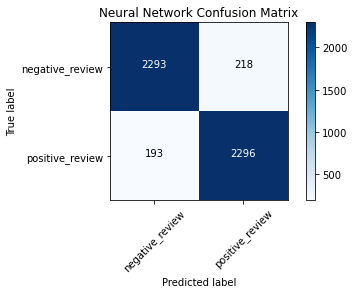

In [143]:
plot_confusion_matrix_nn(cm=cm_nn, title='Neural Network Confusion Matrix')

### Random Forest Classifier Confusion Matrix

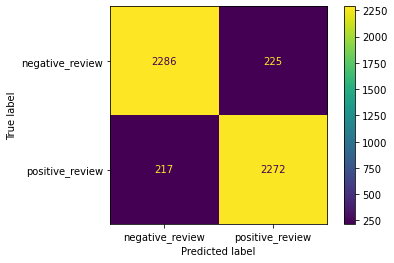

In [145]:
plot_confusion_matrix(rfc, X_test_transformed, y_test, display_labels=cm_plot_labels);